# This notebook serves as the validation fo the correct implementation of the loss functions and their derivatives in CrysX-NN

# Plus, as a benchmark of the speed

## Run the following for Google colab 
then restart runtime

In [1]:
! pip install --upgrade --no-cache-dir https://github.com/manassharma07/crysx_nn/tarball/main
! pip install IPython==7.7.0

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # Ensure that evertyhing is only using CPU¶

import numpy as np
np.show_config()
import matplotlib.pyplot as plt

# Import activation functions from crysx_nn
from crysx_nn.loss import MSE_loss, MSE_loss_grad
from crysx_nn.loss import MAE_loss, MAE_loss_grad
from crysx_nn.loss import BCE_loss, BCE_loss_grad
from crysx_nn.loss import CCE_loss, CCE_loss_grad
import crysx_nn
print('CrysX-NN',crysx_nn.__version__)

# PyTorch
import torch
print('torch',torch.__version__)

# Tensorflow
import tensorflow as tf
print('tensorflow',tf.__version__)

blas_mkl_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
blas_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
lapack_mkl_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
lapack_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = [

## Ensure that evertyhing is only using CPU

In [2]:
torch.cuda.is_available()

False

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [5]:
print(tf.test.is_built_with_cuda())

True


## Generate an input `2d array` of type `float32` for benchmark (let's say using `torch`)

In [2]:
predictions_torch = 100*torch.rand((300,100),requires_grad=True)
print(predictions_torch)
targets_torch = 100*torch.rand((300,100),requires_grad=True)
print(targets_torch)

tensor([[17.9182,  8.2556, 18.2973,  ..., 35.0176, 18.3857, 18.5524],
        [66.8794, 22.6183, 14.7278,  ..., 83.7316, 72.3282, 83.1539],
        [33.9092, 78.8408, 82.5141,  ..., 41.6519, 66.8767, 13.9403],
        ...,
        [58.0017, 64.5535, 61.0339,  ..., 58.7764, 48.9695, 83.5851],
        [47.3194, 29.7700, 62.2835,  ..., 99.9701, 18.1872, 80.3334],
        [ 2.0689, 65.9550, 83.8718,  ..., 37.3190, 89.4423, 22.2085]],
       grad_fn=<MulBackward0>)
tensor([[62.4461, 30.7087, 48.8354,  ...,  8.2351, 85.7602, 77.9174],
        [24.6616, 71.3762, 16.7946,  ...,  2.7224, 66.1342, 94.7130],
        [48.0181, 17.8651,  5.6790,  ..., 80.7293, 27.4824, 67.5123],
        ...,
        [60.1079, 67.8197, 48.4036,  ..., 45.3064, 74.0781, 34.5896],
        [12.5390, 37.4801, 36.5383,  ..., 13.3115, 28.7114, 29.5014],
        [22.8993, 96.6903, 86.1175,  ..., 99.9278, 36.7037, 86.8148]],
       grad_fn=<MulBackward0>)


## Convert it to numpy for `crysx_nn`

In [3]:
predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
print(predictions_crysx_nn.dtype)
targets_crysx_nn = targets_torch.cpu().detach().numpy()
print(targets_crysx_nn.dtype)

float32
float32


## Now finally convert it to a tensorflow tensor

In [4]:
predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)

## Benchmark MSE_loss

### Confirm that all frameworks give the same results

PyTorch expects predictions first then targets

PyTorch - https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html

TensorFlow expects targets first then predictions

Tensorflow - https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError

CrysX-NN doesn't return values averaged over samples. So take care of that.

In [5]:
# Torch
mse_loss_func = torch.nn.MSELoss()
mse_torch_value = mse_loss_func(predictions_torch, targets_torch)

# CrysX
mse_crysx_nn_value = MSE_loss(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]
print(type(mse_crysx_nn_value))

# Tensorflow
mse_tf_func = tf.keras.losses.MeanSquaredError()
mse_tf_value = mse_tf_func(targets_tf, predictions_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(mse_torch_value.cpu().detach().numpy() - mse_tf_value.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(mse_torch_value.cpu().detach().numpy() - mse_crysx_nn_value).max())

<class 'float'>
Max abs diff b/w torch and tf 0.00012207031
Max abs diff b/w torch and CrysX 2.9610769615828758e-05


### Compare performance with arrays of different sizes

In [6]:
time_torch = []
time_crysx_nn = []
time_tf = []
sizes = []

for n_size in range(10,3000,500):
    sizes.append(n_size*n_size)
    # Torch input
    predictions_torch = 100*torch.rand((n_size,n_size),requires_grad=True)
    targets_torch = 100*torch.rand((n_size,n_size),requires_grad=True)
    # CrysX-NN input
    predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
    targets_crysx_nn = targets_torch.cpu().detach().numpy()
    # Tensorflow input
    predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
    targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)
    
    ##--Timings--
    # Torch
    mse_loss_func = torch.nn.MSELoss()
    mse_torch_value = mse_loss_func(predictions_torch, targets_torch)
    time = %timeit -n 500 -o mse_loss_func(predictions_torch, targets_torch)
    # For time of each run
    time_torch.append(np.mean(time.timings)) 
    # For total time
#     time_torch.append(np.mean(time.all_runs)) 
    # CrysX
    mse_crysx_nn_value = MSE_loss(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]
    time = %timeit -n 500 -o MSE_loss(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]
    # For time of each run
    time_crysx_nn.append(np.mean(time.timings))
    # Tensorflow
    mse_tf_func = tf.keras.losses.MeanSquaredError()
    mse_tf_value = mse_tf_func(targets_tf, predictions_tf)
    time = %timeit -n 500 -o mse_tf_func(targets_tf, predictions_tf)
    # For time of each run
    time_tf.append(np.mean(time.timings))
    print('Size:', predictions_crysx_nn.shape)
    #Diff b/w tf and torch
    print('Max abs diff b/w torch and tf', abs(mse_torch_value.cpu().detach().numpy() - mse_tf_value.numpy()).max())
    #Diff b/w crysx_nn and torch
    print('Max abs diff b/w torch and CrysX', abs(mse_torch_value.cpu().detach().numpy() - mse_crysx_nn_value).max())

18.8 µs ± 1.18 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
8.62 µs ± 601 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
163 µs ± 21.6 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
Size: (10, 10)
Max abs diff b/w torch and tf 0.00012207031
Max abs diff b/w torch and CrysX 6.985878576415416e-05
73.2 µs ± 3.3 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
69.9 µs ± 5.47 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
326 µs ± 6.8 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
Size: (510, 510)
Max abs diff b/w torch and tf 0.00012207031
Max abs diff b/w torch and CrysX 7.233142514451174e-05
714 µs ± 26.2 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
182 µs ± 34.9 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
1.17 ms ± 74.6 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
Size: (1010, 1010)
Max abs diff b/w torch and tf 0.00024414062
Max abs diff b/w torch and CrysX 2.889148163376376e-05
1.56 ms ± 2

### Plot the results

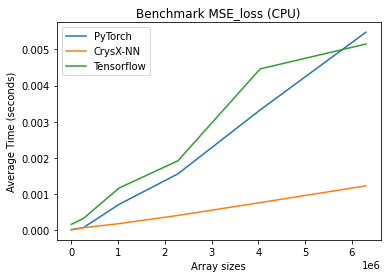

In [7]:

plt.plot(sizes,time_torch, label='PyTorch')
plt.plot(sizes,time_crysx_nn, label='CrysX-NN')
plt.plot(sizes,time_tf, label='Tensorflow')
plt.legend()
plt.xlabel('Array sizes')
plt.ylabel('Average Time (seconds)')
plt.title('Benchmark MSE_loss (CPU)')
# plt.show()
plt.subplots_adjust(left=0.15)
# from google.colab import files
plt.savefig("MSE_loss_CPU.png", transparent=True)
# files.download("MSE_loss_CPU.png") 

### Validate gradients

In [12]:
def tf_mse_grad(targets_tf, predictions_tf):
    with tf.GradientTape() as g:
        g.watch(predictions_tf)
        mse_tf_func = tf.keras.losses.MeanSquaredError()
        mse_tf_value = mse_tf_func(targets_tf, predictions_tf)
    grad = g.gradient(mse_tf_value, predictions_tf)
    return grad#.numpy()

In [13]:
# Torch input
predictions_torch = 10000*torch.rand((2000,3000),requires_grad=True)
targets_torch = 10000*torch.rand((2000,3000),requires_grad=True)
# CrysX-NN input
predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
targets_crysx_nn = targets_torch.cpu().detach().numpy()
# Tensorflow input
predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)

# Torch
mse_loss_func = torch.nn.MSELoss()
mse_torch_value = mse_loss_func(predictions_torch, targets_torch)
mse_torch_value.backward()
gradientTorch = torch.autograd.grad(mse_loss_func(predictions_torch,targets_torch),predictions_torch)[0]
# print(gradientTorch)

# CrysX
gradientCrysX_NN = MSE_loss_grad(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]

# Tensorflow
gradientTF = tf_mse_grad(targets_tf, predictions_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(gradientTorch.cpu().detach().numpy() - gradientTF.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(gradientTorch.cpu().detach().numpy() - gradientCrysX_NN).max())

Max abs diff b/w torch and tf 4.656613e-10
Max abs diff b/w torch and CrysX 2.3283064e-10


## Benchmark BCE_loss

### Confirm that all frameworks give the same results

PyTorch expects predictions first then targets

PyTorch - https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html

TensorFlow expects targets first then predictions

Tensorflow - https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy

CrysX-NN doesn't return values averaged over samples. So take care of that.

In [8]:
# Torch input
predictions_torch = torch.rand((2000,3000),requires_grad=True)
# print(predictions_torch)
targets_torch = torch.randint(low=0,high=2, size=(2000,3000)).float()
# print(targets_torch)
# CrysX-NN input
predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
targets_crysx_nn = targets_torch.cpu().detach().numpy()
# Tensorflow input
predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)

# Torch
bce_loss_func = torch.nn.BCELoss()
bce_torch_value = bce_loss_func(predictions_torch, targets_torch)

# CrysX
bce_crysx_nn_value = BCE_loss(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]
# print(bce_crysx_nn_value)

# Tensorflow
bce_tf_func = tf.keras.losses.BinaryCrossentropy()
bce_tf_value = bce_tf_func(targets_tf, predictions_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(bce_torch_value.cpu().detach().numpy() - bce_tf_value.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(bce_torch_value.cpu().detach().numpy() - bce_crysx_nn_value).max())

Max abs diff b/w torch and tf 1.5497208e-06
Max abs diff b/w torch and CrysX 1.5157959729616977e-06


### Compare performance with arrays of different sizes

In [9]:
time_torch = []
time_crysx_nn = []
time_tf = []
sizes = []

for n_size in range(10,3000,500):
    sizes.append(n_size*n_size)
    # Torch input
    predictions_torch = torch.rand((n_size,n_size),requires_grad=True)
    targets_torch = torch.randint(low=0,high=2, size=(n_size,n_size)).float()
    # CrysX-NN input
    predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
    targets_crysx_nn = targets_torch.cpu().detach().numpy()
    # Tensorflow input
    predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
    targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)
    
    ##--Timings--
    # Torch
    bce_loss_func = torch.nn.BCELoss()
    bce_torch_value = bce_loss_func(predictions_torch, targets_torch)
    time = %timeit -n 100 -o bce_loss_func(predictions_torch, targets_torch)
    # For time of each run
    time_torch.append(np.mean(time.timings)) 
    # For total time
#     time_torch.append(np.mean(time.all_runs)) 
    # CrysX
    bce_crysx_nn_value = BCE_loss(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]
    time = %timeit -n 100 -o BCE_loss(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]
    # For time of each run
    time_crysx_nn.append(np.mean(time.timings))
    # Tensorflow
    bce_tf_func = tf.keras.losses.BinaryCrossentropy()
    bce_tf_value = bce_tf_func(targets_tf, predictions_tf)
    time = %timeit -n 100 -o bce_tf_func(targets_tf, predictions_tf)
    # For time of each run
    time_tf.append(np.mean(time.timings))
    print('Size:', predictions_crysx_nn.shape)
    #Diff b/w tf and torch
    print('Max abs diff b/w torch and tf', abs(bce_torch_value.cpu().detach().numpy() - bce_tf_value.numpy()).max())
    #Diff b/w crysx_nn and torch
    print('Max abs diff b/w torch and CrysX', abs(bce_torch_value.cpu().detach().numpy() - bce_crysx_nn_value).max())

26.2 µs ± 4.25 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
14.1 µs ± 2.67 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
395 µs ± 68.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Size: (10, 10)
Max abs diff b/w torch and tf 9.536743e-07
Max abs diff b/w torch and CrysX 9.001866625446553e-07
855 µs ± 17.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
864 µs ± 21 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.13 ms ± 42.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Size: (510, 510)
Max abs diff b/w torch and tf 3.5762787e-06
Max abs diff b/w torch and CrysX 3.5684169303884516e-06
3.53 ms ± 28.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.1 ms ± 171 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.7 ms ± 558 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Size: (1010, 1010)
Max abs diff b/w torch and tf 2.9802322e-06
Max abs diff b/w torch and CrysX 3.0615219090979195e-06
7.75 ms ± 3

### Plot the results

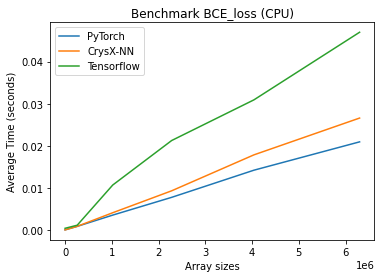

In [10]:

plt.plot(sizes,time_torch, label='PyTorch')
plt.plot(sizes,time_crysx_nn, label='CrysX-NN')
plt.plot(sizes,time_tf, label='Tensorflow')
plt.legend()
plt.xlabel('Array sizes')
plt.ylabel('Average Time (seconds)')
plt.title('Benchmark BCE_loss (CPU)')
# plt.show()
plt.subplots_adjust(left=0.15)
plt.savefig("BCE_loss_CPU.png", transparent=True)
# files.download("BCE_loss_CPU.png")

### Validate gradients

In [17]:
def tf_bce_grad(targets_tf, predictions_tf):
    with tf.GradientTape() as g:
        g.watch(predictions_tf)
        bce_tf_func = tf.keras.losses.BinaryCrossentropy()
        bce_tf_value = bce_tf_func(targets_tf, predictions_tf)
    grad = g.gradient(bce_tf_value, predictions_tf)
    return grad#.numpy()

In [18]:
nSamples = 2000
nOutputs = 3000#nClasess
# Torch input
predictions_torch_ = torch.rand((nSamples,nOutputs),requires_grad=True)
# print(predictions_torch)
# Predictions are supposed to be probabilities from 0 to 1, summing upto 1.
# Therefore, apply a softmax on them
m = torch.nn.Softmax()
predictions_torch = m(predictions_torch_)
# print(predictions_torch)
# Generate random one hot vectors matrix
# No. of classes
n = nOutputs
target_indices = torch.randint(1,n, size=(1,nSamples)).reshape(nSamples) # Get a 1D tensor index of size =nSamples=2000
# print(target_indices)
# print(target_indices.shape)
# Convert the index tensor to one-hot encoded vectors matrix
target_one_hot = torch.nn.functional.one_hot(target_indices, n) # size=(4,7,n)
targets_torch = target_one_hot.float() # torch.randint(low=0,high=2, size=(2000,3000)).float()
# print(targets_torch)
# print(targets_torch.shape)
# CrysX-NN input
predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
targets_crysx_nn = targets_torch.cpu().detach().numpy()
# Tensorflow input
predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)

# Torch
bce_loss_func = torch.nn.BCELoss()
bce_torch_value = bce_loss_func(predictions_torch, targets_torch)
bce_torch_value.backward()
gradientTorch = torch.autograd.grad(bce_loss_func(predictions_torch,targets_torch),predictions_torch)[0]
# print(gradientTorch)

# CrysX
gradientCrysX_NN = BCE_loss_grad(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]

# Tensorflow
gradientTF = tf_bce_grad(targets_tf, predictions_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(gradientTorch.cpu().detach().numpy() - gradientTF.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(gradientTorch.cpu().detach().numpy() - gradientCrysX_NN).max())

C:\Users\manas\anaconda3\envs\crysx_nn\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


Max abs diff b/w torch and tf 4.4319313e-07
Max abs diff b/w torch and CrysX 1.1641532e-10


## Benchmark MAE_loss

### Confirm that all frameworks give the same results

PyTorch expects predictions first then targets

PyTorch - https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html

TensorFlow expects targets first then predictions

Tensorflow - https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanAbsoluteError

CrysX-NN doesn't return values averaged over samples. So take care of that.

In [11]:
# Torch
predictions_torch = 100*torch.rand((300,100),requires_grad=True)
targets_torch = 100*torch.rand((300,100),requires_grad=True)
# CrysX
predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
targets_crysx_nn = targets_torch.cpu().detach().numpy()
# TensorFlow
predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)

# Torch
mae_loss_func = torch.nn.L1Loss()
mae_torch_value = mae_loss_func(predictions_torch, targets_torch)

# CrysX
mae_crysx_nn_value = MAE_loss(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]
print(type(mae_crysx_nn_value))

# Tensorflow
mae_tf_func = tf.keras.losses.MeanAbsoluteError()
mae_tf_value = mae_tf_func(targets_tf, predictions_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(mae_torch_value.cpu().detach().numpy() - mae_tf_value.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(mae_torch_value.cpu().detach().numpy() - mae_crysx_nn_value).max())

<class 'float'>
Max abs diff b/w torch and tf 3.8146973e-06
Max abs diff b/w torch and CrysX 1.756056150270524e-06


### Compare performance with arrays of different sizes

In [12]:
time_torch = []
time_crysx_nn = []
time_tf = []
sizes = []

for n_size in range(10,3000,500):
    sizes.append(n_size*n_size)
    # Torch input
    predictions_torch = 100*torch.rand((n_size,n_size),requires_grad=True)
    targets_torch = 100*torch.rand((n_size,n_size),requires_grad=True)
    # CrysX-NN input
    predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
    targets_crysx_nn = targets_torch.cpu().detach().numpy()
    # Tensorflow input
    predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
    targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)
    
    ##--Timings--
    # Torch
    mae_loss_func = torch.nn.L1Loss()
    mae_torch_value = mae_loss_func(predictions_torch, targets_torch)
    time = %timeit -n 300 -o mae_loss_func(predictions_torch, targets_torch)
    # For time of each run
    time_torch.append(np.mean(time.timings)) 
    # For total time
#     time_torch.append(np.mean(time.all_runs)) 
    # CrysX
    mae_crysx_nn_value = MAE_loss(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]
    time = %timeit -n 300 -o MAE_loss(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]
    # For time of each run
    time_crysx_nn.append(np.mean(time.timings))
    # Tensorflow
    mae_tf_func = tf.keras.losses.MeanAbsoluteError()
    mae_tf_value = mae_tf_func(targets_tf, predictions_tf)
    time = %timeit -n 300 -o mae_tf_func(targets_tf, predictions_tf)
    # For time of each run
    time_tf.append(np.mean(time.timings))
    print('Size:', predictions_crysx_nn.shape)
    #Diff b/w tf and torch
    print('Max abs diff b/w torch and tf', abs(mae_torch_value.cpu().detach().numpy() - mae_tf_value.numpy()).max())
    #Diff b/w crysx_nn and torch
    print('Max abs diff b/w torch and CrysX', abs(mae_torch_value.cpu().detach().numpy() - mae_crysx_nn_value).max())

23.2 µs ± 962 ns per loop (mean ± std. dev. of 7 runs, 300 loops each)
12.3 µs ± 1.63 µs per loop (mean ± std. dev. of 7 runs, 300 loops each)
184 µs ± 33.5 µs per loop (mean ± std. dev. of 7 runs, 300 loops each)
Size: (10, 10)
Max abs diff b/w torch and tf 0.0
Max abs diff b/w torch and CrysX 1.764297486772648e-06
177 µs ± 4.07 µs per loop (mean ± std. dev. of 7 runs, 300 loops each)
52.6 µs ± 2.49 µs per loop (mean ± std. dev. of 7 runs, 300 loops each)
392 µs ± 23.4 µs per loop (mean ± std. dev. of 7 runs, 300 loops each)
Size: (510, 510)
Max abs diff b/w torch and tf 0.0
Max abs diff b/w torch and CrysX 2.4037835544277186e-07
1.08 ms ± 21.8 µs per loop (mean ± std. dev. of 7 runs, 300 loops each)
152 µs ± 25.9 µs per loop (mean ± std. dev. of 7 runs, 300 loops each)
2.1 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 300 loops each)
Size: (1010, 1010)
Max abs diff b/w torch and tf 3.8146973e-06
Max abs diff b/w torch and CrysX 2.545976670376149e-06
2.49 ms ± 87.9 µs per loop (me

### Plot the results

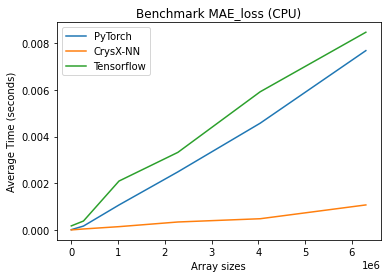

In [13]:

plt.plot(sizes,time_torch, label='PyTorch')
plt.plot(sizes,time_crysx_nn, label='CrysX-NN')
plt.plot(sizes,time_tf, label='Tensorflow')
plt.legend()
plt.xlabel('Array sizes')
plt.ylabel('Average Time (seconds)')
plt.title('Benchmark MAE_loss (CPU)')
# plt.show()
plt.subplots_adjust(left=0.15)
plt.savefig("MAE_loss_CPU.png", transparent=True)
# files.download("MAE_loss_CPU.png")

### Validate gradients

In [22]:
def tf_mae_grad(targets_tf, predictions_tf):
    with tf.GradientTape() as g:
        g.watch(predictions_tf)
        mae_tf_func = tf.keras.losses.MeanAbsoluteError()
        mae_tf_value = mae_tf_func(targets_tf, predictions_tf)
    grad = g.gradient(mae_tf_value, predictions_tf)
    return grad#.numpy()

In [23]:
# Torch input
predictions_torch = 10000*torch.rand((2000,3000),requires_grad=True)
targets_torch = 10000*torch.rand((2000,3000),requires_grad=True)
# CrysX-NN input
predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
targets_crysx_nn = targets_torch.cpu().detach().numpy()
# Tensorflow input
predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)

# Torch
mae_loss_func = torch.nn.L1Loss()
mae_torch_value = mae_loss_func(predictions_torch, targets_torch)
mae_torch_value.backward()
gradientTorch = torch.autograd.grad(mae_loss_func(predictions_torch,targets_torch),predictions_torch)[0]
# print(gradientTorch)

# CrysX
gradientCrysX_NN = MAE_loss_grad(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]
# print(gradientCrysX_NN)


# Tensorflow
gradientTF = tf_mae_grad(targets_tf, predictions_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(gradientTorch.cpu().detach().numpy() - gradientTF.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(gradientTorch.cpu().detach().numpy() - gradientCrysX_NN).max())

Max abs diff b/w torch and tf 1.4210855e-14
Max abs diff b/w torch and CrysX 4.2079286565503357e-16


## Benchmark CCE_loss

### Confirm that all frameworks give the same results

PyTorch expects predictions first then targets

PyTorch - https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

TensorFlow expects targets first then predictions

Tensorflow - https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy

CrysX-NN doesn't return values averaged over samples. So take care of that.

<b>Note:</b> TensorFlow and CrysX-NN expect one-hot encoded vectors.
<b>Note:</b> Unfortunately, PyTorch computes the Cross Entropy in a weird fashion. It expects the inputs to not be probabilities. Rather it computes the probabilities from the inputs using the Softmax function and then returns the Cross Entropy Loss.https://stackoverflow.com/questions/49390842/cross-entropy-in-pytorch

Unrelated but useful info some of the answers and comments for future reference: https://stackoverflow.com/questions/42081257/why-binary-crossentropy-and-categorical-crossentropy-give-different-performances

In [14]:
nSamples = 2000
nOutputs = 3000 #nClasess
# Torch input
predictions_torch_ = torch.rand((nSamples,nOutputs),requires_grad=True)
# print(predictions_torch)
# Predictions are supposed to be probabilities from 0 to 1, summing upto 1.
# Therefore, apply a softmax on them
m = torch.nn.Softmax()
predictions_torch = m(predictions_torch_)
# print(predictions_torch)
# Generate random one hot vectors matrix
# No. of classes
n = nOutputs
target_indices = torch.randint(1,n, size=(1,nSamples)).reshape(nSamples) # Get a 1D tensor index of size =nSamples=2000
# print(target_indices)
# print(target_indices.shape)

# Convert the index tensor to one-hot encoded vectors matrix
target_one_hot = torch.nn.functional.one_hot(target_indices, n) # size=(4,7,n)
targets_torch = target_one_hot.float() # torch.randint(low=0,high=2, size=(2000,3000)).float()
# print(targets_torch)
# print(targets_torch.shape)

# CrysX-NN input
predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
targets_crysx_nn = targets_torch.cpu().detach().numpy()

# Tensorflow input
predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)

# Torch
cce_loss_func = torch.nn.CrossEntropyLoss()
# cce_loss_func = torch.nn.NLLLoss()
# cce_torch_value = cce_loss_func(predictions_torch_, targets_torch) # Don't use one-hot vectors for PyTorch
cce_torch_value = cce_loss_func(predictions_torch_, target_indices) # Use the class/target indices directly for Pytorch
# print(cce_torch_value)

# CrysX
# Default epsilon=1e-9 (gives exactly the same answer as tensorflow)
cce_crysx_nn_value = CCE_loss(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]
# print(cce_crysx_nn_value)

# Tensorflow
cce_tf_func = tf.keras.losses.CategoricalCrossentropy()
cce_tf_value = cce_tf_func(targets_tf, predictions_tf)
# print(cce_tf_value)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(cce_torch_value.cpu().detach().numpy() - cce_tf_value.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(cce_torch_value.cpu().detach().numpy() - cce_crysx_nn_value).max())


C:\Users\manas\anaconda3\envs\crysx_nn\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


Max abs diff b/w torch and tf 1.9073486e-06
Max abs diff b/w torch and CrysX 2.2099711145529e-06


### Compare performance with arrays of different sizes

In [15]:
time_torch = []
time_crysx_nn = []
time_tf = []
sizes = []

for n_size in range(10,3000,500):
    sizes.append(n_size*n_size)
    # Torch input
    predictions_torch_ = torch.rand((n_size,n_size),requires_grad=True)
    # Predictions are supposed to be probabilities from 0 to 1, summing upto 1.
    # Therefore, apply a softmax on them
    m = torch.nn.Softmax()
    predictions_torch = m(predictions_torch_)
    # Generate random one hot vectors matrix
    # No. of classes
    n = n_size
    target_indices = torch.randint(1,n, size=(1,n_size)).reshape(n_size) # Get a 1D tensor index of size =nSamples=2000
    # Convert the index tensor to one-hot encoded vectors matrix
    target_one_hot = torch.nn.functional.one_hot(target_indices, n) # size=(4,7,n)
    targets_torch = target_one_hot.float() # torch.randint(low=0,high=2, size=(2000,3000)).float()
    # CrysX-NN input
    predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
    targets_crysx_nn = targets_torch.cpu().detach().numpy()
    # Tensorflow input
    predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
    targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)
    
    ##--Timings--
    # Torch
    cce_loss_func = torch.nn.CrossEntropyLoss()
    cce_torch_value = cce_loss_func(predictions_torch_, targets_torch)
    time = %timeit -n 100 -o cce_loss_func(predictions_torch_, target_indices)
    # For time of each run
    time_torch.append(np.mean(time.timings)) 
    # For total time
#     time_torch.append(np.mean(time.all_runs)) 
    # CrysX
    cce_crysx_nn_value = CCE_loss(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]
    time = %timeit -n 100 -o CCE_loss(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]
    # For time of each run
    time_crysx_nn.append(np.mean(time.timings))
    # Tensorflow
    cce_tf_func = tf.keras.losses.CategoricalCrossentropy()
    cce_tf_value = cce_tf_func(targets_tf, predictions_tf)
    time = %timeit -n 100 -o cce_tf_func(targets_tf, predictions_tf)
    # For time of each run
    time_tf.append(np.mean(time.timings))
    print('Size:', predictions_crysx_nn.shape)
    #Diff b/w tf and torch
    print('Max abs diff b/w torch and tf', abs(cce_torch_value.cpu().detach().numpy() - cce_tf_value.numpy()).max())
    #Diff b/w crysx_nn and torch
    print('Max abs diff b/w torch and CrysX', abs(cce_torch_value.cpu().detach().numpy() - cce_crysx_nn_value).max())

16.5 µs ± 3.58 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
78 µs ± 7.61 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


C:\Users\manas\anaconda3\envs\crysx_nn\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


285 µs ± 24.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Size: (10, 10)
Max abs diff b/w torch and tf 2.3841858e-07
Max abs diff b/w torch and CrysX 1.3869643478159333e-07
2.07 ms ± 120 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.25 ms ± 53.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
709 µs ± 8.08 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Size: (510, 510)
Max abs diff b/w torch and tf 4.7683716e-07
Max abs diff b/w torch and CrysX 9.909313813949439e-07
5.87 ms ± 222 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.17 ms ± 157 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.65 ms ± 139 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Size: (1010, 1010)
Max abs diff b/w torch and tf 0.0
Max abs diff b/w torch and CrysX 1.347994310840761e-06
8.79 ms ± 574 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
19.9 ms ± 559 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.48 ms ± 175 µs per 

### Plot the results

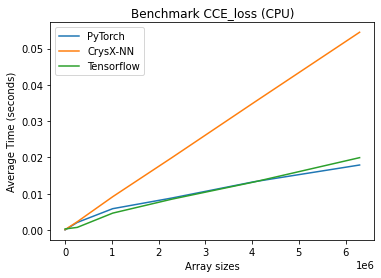

In [16]:

plt.plot(sizes,time_torch, label='PyTorch')
plt.plot(sizes,time_crysx_nn, label='CrysX-NN')
plt.plot(sizes,time_tf, label='Tensorflow')
plt.legend()
plt.xlabel('Array sizes')
plt.ylabel('Average Time (seconds)')
plt.title('Benchmark CCE_loss (CPU)')
# plt.show()
plt.subplots_adjust(left=0.15)
plt.savefig("CCE_loss_CPU.png", transparent=True)
# files.download("CCE_loss_CPU.png")

### Validate gradients